In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import time

In [2]:
from dataset import Step5_DataSet
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
import kgml_lib
Z_norm_reverse = kgml_lib.Z_norm_reverse
Z_norm_with_scaler = kgml_lib.Z_norm_with_scaler

### Here use CO2 finetune dataset as example

In [5]:
# Load dataset
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

co2_finetune_file = data_path + 'co2_finetune_data.sav'
data = torch.load(co2_finetune_file, weights_only=False)

In [6]:
X_train = data['X_train']
X_test = data['X_test']
Y_train = data['Y_train']
Y_test  = data['Y_test']

y_scaler = data['y_scaler']

In [7]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, y_scaler.shape

(torch.Size([1, 37230, 19]),
 torch.Size([1, 37230, 2]),
 torch.Size([1, 8030, 19]),
 torch.Size([1, 8030, 2]),
 (2, 2))

In [9]:
# Set parameters for create a Module
num_input_features = 19
num_output_features = 2

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

### Choose one of the models below:
<ol>
<li>model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)</li>
<li>model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)</li>
<li>model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)</li>
<li>model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)</li>
</ol>

In [10]:
model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

### 1D CNN models

In [11]:
from time_series_models import TemporalCNN, CNNLSTM, CNN_LSTM_Attension

In [12]:
# Set parameters for create a Module
num_input_features = 19
num_output_features = 2

input_dim = num_input_features
hidden_dim = 256
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [13]:
model = TemporalCNN(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [33]:
model = CNNLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [41]:
model = CNN_LSTM_Attension(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [42]:
# Create Pytorch dataloader
sequence_length = 365  # Use 365 consecutive days as a sample

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

# Create DataLoaders.
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [43]:
learning_rate = 0.001
step_size = 40
max_epoch = 120
gamma = 0.8
loss_function = nn.L1Loss() # nn.MSELoss()

model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/120 | LR: 0.001000, Train Loss: 1.5069, Test Loss: 1.0403
Epoch 2/120 | LR: 0.001000, Train Loss: 0.9012, Test Loss: 0.7528
Epoch 3/120 | LR: 0.001000, Train Loss: 0.6347, Test Loss: 0.5904
Epoch 4/120 | LR: 0.001000, Train Loss: 0.5433, Test Loss: 0.3906
Epoch 5/120 | LR: 0.001000, Train Loss: 0.4359, Test Loss: 0.3962
Epoch 6/120 | LR: 0.001000, Train Loss: 0.4034, Test Loss: 0.3466
Epoch 7/120 | LR: 0.001000, Train Loss: 0.3574, Test Loss: 0.3094
Epoch 8/120 | LR: 0.001000, Train Loss: 0.3515, Test Loss: 0.3172
Epoch 9/120 | LR: 0.001000, Train Loss: 0.3221, Test Loss: 0.3118
Epoch 10/120 | LR: 0.001000, Train Loss: 0.3275, Test Loss: 0.2882
Epoch 11/120 | LR: 0.001000, Train Loss: 0.3102, Test Loss: 0.2741
Epoch 12/120 | LR: 0.001000, Train Loss: 0.2963, Test Loss: 0.2675
Epoch 13/120 | LR: 0.001000, Train Loss: 0.2853, Test Loss: 0.2782
Epoch 14/120 | LR: 0.001000, Train Loss: 0.2823, Test Loss: 0.2768
Epoch 15/120 | LR: 0.001000, Train Loss: 0.2830, Test Loss: 0.2806
Epoc

In [44]:
model.test()

Test Loss: 0.1981


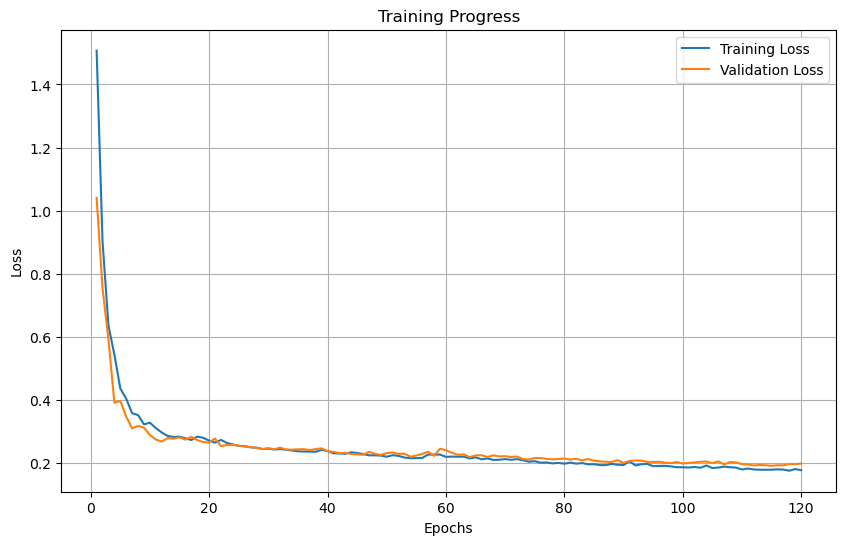

In [45]:
model.plot_training_curves()

In [46]:
output_feature_name = ['NEE','RECO']
model.get_R2_score(y_scaler, output_feature_name)

Feature NEE R2 Score is: 0.8810256371484719
Feature RECO R2 Score is: 0.87212200786533


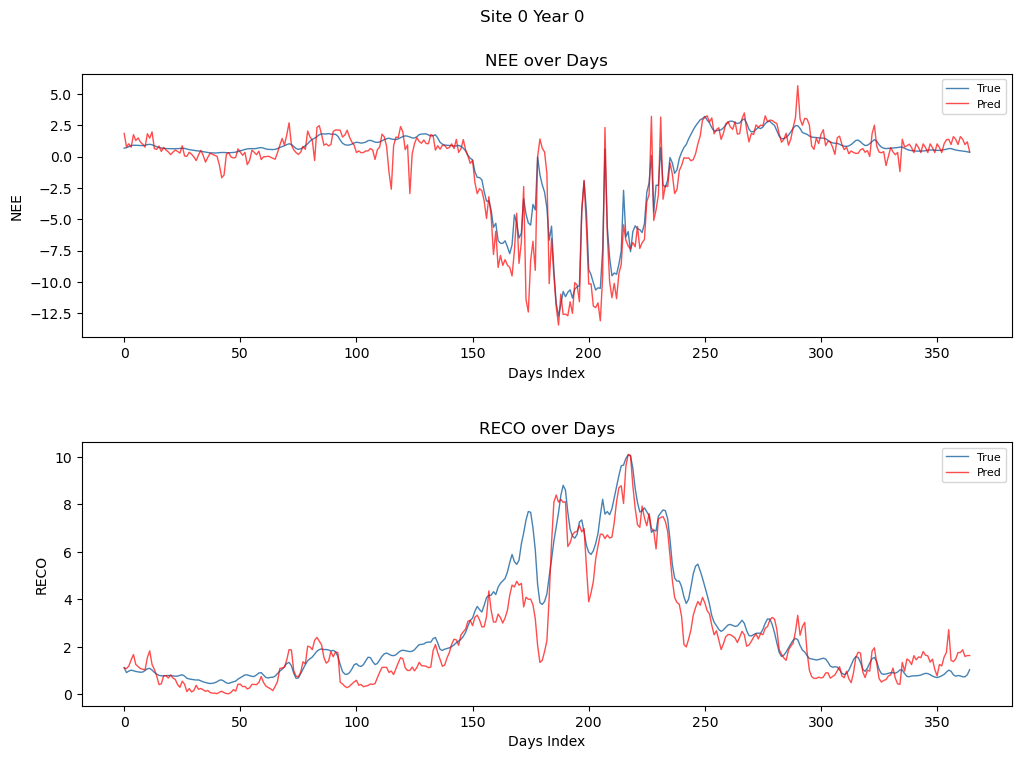

In [47]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=0, year=0)

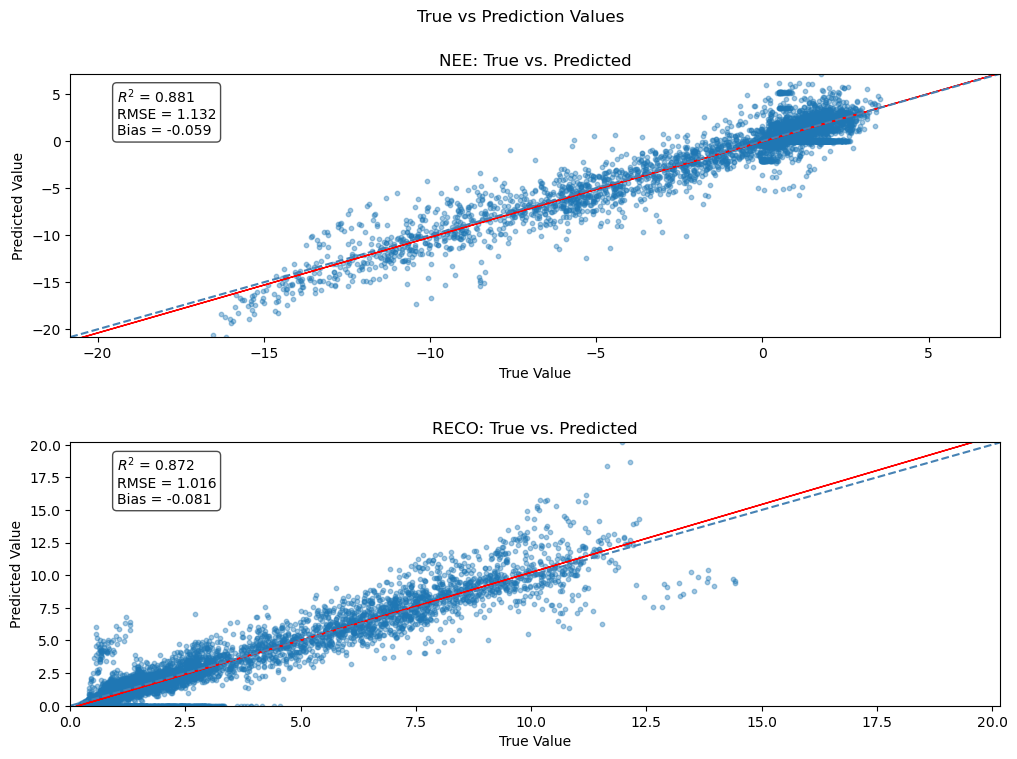

In [48]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)